In [1]:
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
df = pd.read_csv('./data/fl_reg_name_race_2022.csv.gz')

In [3]:
df.head()

,name_last,name_first,race
0,Hessler-Smith,Jason,nh_white
1,Rogers,Renee,nh_white
2,Bartolome,Crystal,nh_white
3,Bailey,Donna,nh_white
4,Carlson,Greggory,nh_white


In [4]:
df.describe()

,name_last,name_first,race
count,15454992,15455022,15455110
unique,1341195,641103,8
top,Smith,Michael,nh_white
freq,79362,153753,9446851


In [5]:
df['race'].unique()

array(['nh_white', 'nh_black', 'other', 'hispanic', 'asian',
       'native_indian', 'unknown', 'multi_racial'], dtype=object)

## Drop none values

In [6]:
df.dropna(subset=['name_first', 'name_last'], inplace=True)

In [7]:
df.describe()

,name_last,name_first,race
count,15454908,15454908,15454908
unique,1341176,641095,8
top,Smith,Michael,nh_white
freq,79362,153753,9446749


## drop last name and first name of length 1

In [8]:
df = df.drop(df[df['name_last'].str.len() < 2].index)

In [9]:
df = df.drop(df[df['name_first'].str.len() < 2].index)

In [10]:
df.describe()

,name_last,name_first,race
count,15366690,15366690,15366690
unique,1340617,641055,8
top,Smith,Michael,nh_white
freq,79297,153752,9383680


## Remove special characters

In [11]:
df['full_name'] = df['name_last'] + ' ' + df['name_first']

In [12]:
df.head()

,name_last,name_first,race,full_name
0,Hessler-Smith,Jason,nh_white,Hessler-Smith Jason
1,Rogers,Renee,nh_white,Rogers Renee
2,Bartolome,Crystal,nh_white,Bartolome Crystal
3,Bailey,Donna,nh_white,Bailey Donna
4,Carlson,Greggory,nh_white,Carlson Greggory


In [13]:
df['full_name'] = df['full_name'].str.replace('[^a-zA-Z ]', '', regex=True)

In [14]:
df.head()

,name_last,name_first,race,full_name
0,Hessler-Smith,Jason,nh_white,HesslerSmith Jason
1,Rogers,Renee,nh_white,Rogers Renee
2,Bartolome,Crystal,nh_white,Bartolome Crystal
3,Bailey,Donna,nh_white,Bailey Donna
4,Carlson,Greggory,nh_white,Carlson Greggory


## drop duplicates

In [15]:
df[df[['full_name','race']].duplicated()]

,name_last,name_first,race,full_name
837,Moser,Patricia,nh_white,Moser Patricia
928,Johnson,Tiffany,nh_black,Johnson Tiffany
1247,Perry,Charles,nh_white,Perry Charles
2120,Johnson,Ashley,nh_black,Johnson Ashley
2285,Johnson,Clayton,nh_white,Johnson Clayton
...,...,...,...,...
15455101,Jones,Margaret,nh_white,Jones Margaret
15455102,Hartley,Brandon,nh_white,Hartley Brandon
15455104,Ballentine,Robert,nh_white,Ballentine Robert
15455106,Watts,Mark,nh_white,Watts Mark


In [16]:
df[df['full_name'] == "Porter Paula"]

,name_last,name_first,race,full_name
136,Porter,Paula,nh_white,Porter Paula
550,Porter,Paula,nh_black,Porter Paula
1527456,Porter,Paula,nh_white,Porter Paula
7563599,Porter,Paula,nh_white,Porter Paula
7631191,Porter,Paula,nh_white,Porter Paula
8383292,Porter,Paula,nh_white,Porter Paula
10682106,Porter,Paula,nh_white,Porter Paula


In [17]:
df = df.drop_duplicates(['full_name','race'],keep= 'last')

In [18]:
df[df['full_name'] == "Porter Paula"]

,name_last,name_first,race,full_name
550,Porter,Paula,nh_black,Porter Paula
10682106,Porter,Paula,nh_white,Porter Paula


In [19]:
df.shape

(10809021, 4)

## Extract features

In [20]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False)

In [21]:
X = vectorizer.fit_transform(df['full_name'])

In [22]:
X[:10].toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [23]:
vectorizer.get_feature_names_out()

array([' ', ' A', ' B', ..., 'zx', 'zy', 'zz'], dtype=object)

In [24]:
len(vectorizer.get_feature_names_out())

2767

In [25]:
vocab = vectorizer.get_feature_names_out()

In [26]:
set(df.race.factorize()[0])

{0, 1, 2, 3, 4, 5, 6, 7}

In [27]:
df['race_code'] = df.race.factorize()[0]

In [28]:
df.head()

,name_last,name_first,race,full_name,race_code
0,Hessler-Smith,Jason,nh_white,HesslerSmith Jason,0
2,Bartolome,Crystal,nh_white,Bartolome Crystal,0
4,Carlson,Greggory,nh_white,Carlson Greggory,0
5,McDowell,Terrica,nh_black,McDowell Terrica,1
6,Luong,Lin,other,Luong Lin,2


In [29]:
df[['race', 'race_code']].drop_duplicates().sort_values('race_code')

,race,race_code
0,nh_white,0
5,nh_black,1
6,other,2
22,hispanic,3
32,asian,4
66,native_indian,5
158,multi_racial,6
610,unknown,7


In [30]:
race_id_df = df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)

In [31]:
race_to_id

{'nh_white': 0,
 'nh_black': 1,
 'other': 2,
 'hispanic': 3,
 'asian': 4,
 'native_indian': 5,
 'multi_racial': 6,
 'unknown': 7}

In [32]:
id_to_race = dict(race_id_df[['race_code', 'race']].values)

In [33]:
id_to_race

{0: 'nh_white',
 1: 'nh_black',
 2: 'other',
 3: 'hispanic',
 4: 'asian',
 5: 'native_indian',
 6: 'multi_racial',
 7: 'unknown'}

In [34]:
y = df.race_code

In [35]:
y[0]

0

In [36]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
#Create a Gaussian Classifier
clf = GradientBoostingClassifier(random_state=42, verbose=6)

In [38]:
print(X_train.shape)
print(X_test.shape)

(8647216, 2767)
(2161805, 2767)


## Training

## Doing it for 1 million with 100 iterations

In [42]:
%%time
#Train the model using the training sets y_pred=clf.predict(X_test)

# 1 million
samples = 100 * 100 * 100
# 1 million records took 2h 10min 13s
# 8 million records will take ~17 hours

clf.fit(X_train[:samples], y_train[:samples])

      Iter       Train Loss   Remaining Time 
         1           1.2455          111.68m
         2           1.2283          108.63m
         3           1.2148          106.66m
         4           1.2043          105.27m
         5           1.1939          104.14m
         6           1.1868          101.46m
         7           1.1794           99.75m
         8           1.1738           98.51m
         9           1.1684           97.25m
        10           1.1636           96.15m
        11           1.1589           95.10m
        12           1.1544           94.63m
        13           1.1504           93.49m
        14           1.1466           92.30m
        15           1.1428           91.15m
        16           1.1397           89.91m
        17           1.1369           88.80m
        18           1.1340           87.68m
        19           1.1315           86.45m
        20           1.1285           85.31m
        21           1.1262           84.17m
        2

GradientBoostingClassifier(random_state=42, verbose=6)

In [43]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.655368546191724
CPU times: user 48.2 s, sys: 2.62 s, total: 50.8 s
Wall time: 58.4 s


In [44]:
joblib.dump(vectorizer, "fl_voter_name_gb_vect_1M.joblib", compress=3)  # compression is ON!

['fl_voter_name_gb_vect_1M.joblib']

In [45]:
joblib.dump(clf, "fl_voter_name_gb_model_1M.joblib", compress=3)  # compression is ON!

['fl_voter_name_gb_model_1M.joblib']

## Doing it for 2 million with 100 iterations

In [46]:
%%time
#Train the model using the training sets y_pred=clf.predict(X_test)
clf = GradientBoostingClassifier(random_state=42, verbose=6)

# 2 million
samples = 2 * 100 * 100 * 100
# 1 million records took 2h 10min 13s
# 2 million records took 3h 50 mins
# 8 million records will take ~17 hours

clf.fit(X_train[:samples], y_train[:samples])

      Iter       Train Loss   Remaining Time 
         1           1.2455          259.82m
         2           1.2282          255.67m
         3           1.2151          252.34m
         4           1.2045          248.67m
         5           1.1946          244.61m
         6           1.1873          241.55m
         7           1.1800          239.23m
         8           1.1741          236.18m
         9           1.1685          233.78m
        10           1.1638          230.52m
        11           1.1592          227.62m
        12           1.1545          224.47m
        13           1.1507          221.92m
        14           1.1468          218.90m
        15           1.1433          216.33m
        16           1.1399          213.68m
        17           1.1368          210.78m
        18           1.1338          207.60m
        19           1.1313          204.49m
        20           1.1288          200.83m
        21           1.1260          197.54m
        2

GradientBoostingClassifier(random_state=42, verbose=6)

In [47]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6553865866717858
CPU times: user 37.3 s, sys: 3.64 s, total: 40.9 s
Wall time: 47.8 s


In [48]:
joblib.dump(vectorizer, "fl_voter_name_gb_vect_2M.joblib", compress=3)  # compression is ON!

['fl_voter_name_gb_vect_2M.joblib']

In [49]:
joblib.dump(clf, "fl_voter_name_gb_model_2M.joblib", compress=3)  # compression is ON!

['fl_voter_name_gb_model_2M.joblib']

# Now lets do for the whole train dataset with 20 iterations

In [39]:
%%time

clf = GradientBoostingClassifier(n_estimators=20, random_state=42, verbose=6)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2454          279.97m
         2           1.2283          260.36m
         3           1.2153          243.58m
         4           1.2045          229.15m
         5           1.1947          214.38m
         6           1.1872          200.97m
         7           1.1801          186.81m
         8           1.1743          172.44m
         9           1.1685          157.57m
        10           1.1641          143.10m
        11           1.1594          128.65m
        12           1.1549          113.91m
        13           1.1509           99.47m
        14           1.1471           85.01m
        15           1.1441           70.49m
        16           1.1410           56.24m
        17           1.1377           42.09m
        18           1.1348           27.98m
        19           1.1322           13.97m
        20           1.1293            0.00s
CPU times: user 4h 22min 11s, sys: 16min 34s, total: 4

GradientBoostingClassifier(n_estimators=20, random_state=42, verbose=6)

In [40]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6326995265530425
CPU times: user 32.9 s, sys: 2.97 s, total: 35.9 s
Wall time: 46.2 s


In [41]:
joblib.dump(vectorizer, "fl_voter_name_gb_vect.joblib", compress=3)  # compression is ON!

['fl_voter_name_gb_vect.joblib']

In [42]:
joblib.dump(clf, "fl_voter_name_gb_model.joblib", compress=3)  # compression is ON!

['fl_voter_name_gb_model.joblib']

In [43]:
!~/pushover "ethnicolor job is done" 1 whistle

{"status":1,"request":"a70aa5c1-0e8e-4ce3-9903-d3636607ff8d"}

## Confusion Matrix

### For 1M model

In [68]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 106.9 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.7 kB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 123.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 KB 248.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 KB 102.4 kB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


               precision    recall  f1-score   support

        asian       0.70      0.07      0.13     57636
     hispanic       0.71      0.51      0.59    357839
 multi_racial       0.01      0.00      0.00     16776
native_indian       0.01      0.00      0.00      9397
     nh_black       0.70      0.05      0.09    318456
     nh_white       0.65      0.96      0.77   1263354
        other       0.24      0.00      0.01     55480
      unknown       0.04      0.00      0.00     82867

     accuracy                           0.66   2161805
    macro avg       0.38      0.20      0.20   2161805
 weighted avg       0.63      0.66      0.57   2161805



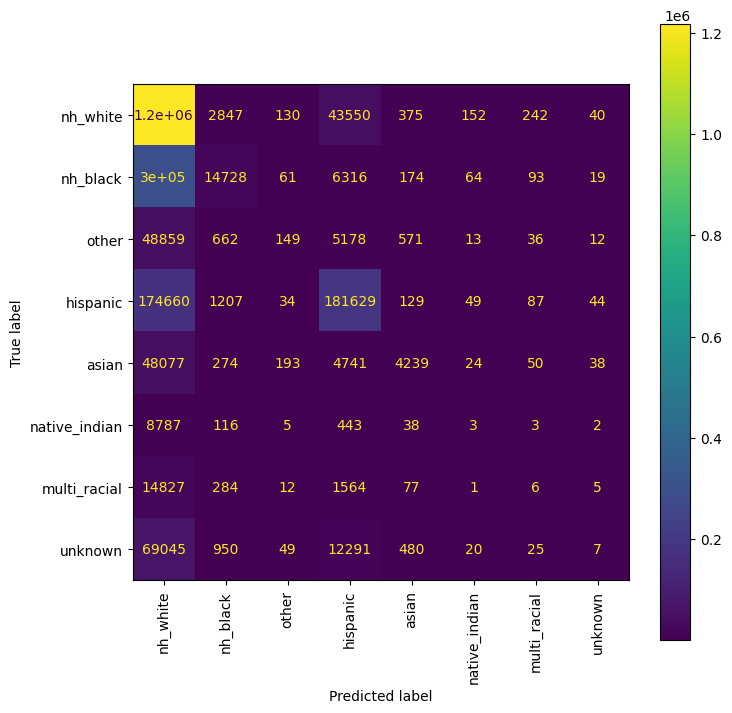

In [69]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline  

model_1m = joblib.load('fl_voter_name_gb_model_1M.joblib')
preds = model_1m.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

### For 2M Model

               precision    recall  f1-score   support

        asian       0.70      0.07      0.13     57636
     hispanic       0.71      0.51      0.59    357839
 multi_racial       0.03      0.00      0.00     16776
native_indian       0.14      0.00      0.01      9397
     nh_black       0.71      0.05      0.09    318456
     nh_white       0.65      0.96      0.77   1263354
        other       0.27      0.00      0.00     55480
      unknown       0.03      0.00      0.00     82867

     accuracy                           0.66   2161805
    macro avg       0.40      0.20      0.20   2161805
 weighted avg       0.63      0.66      0.57   2161805



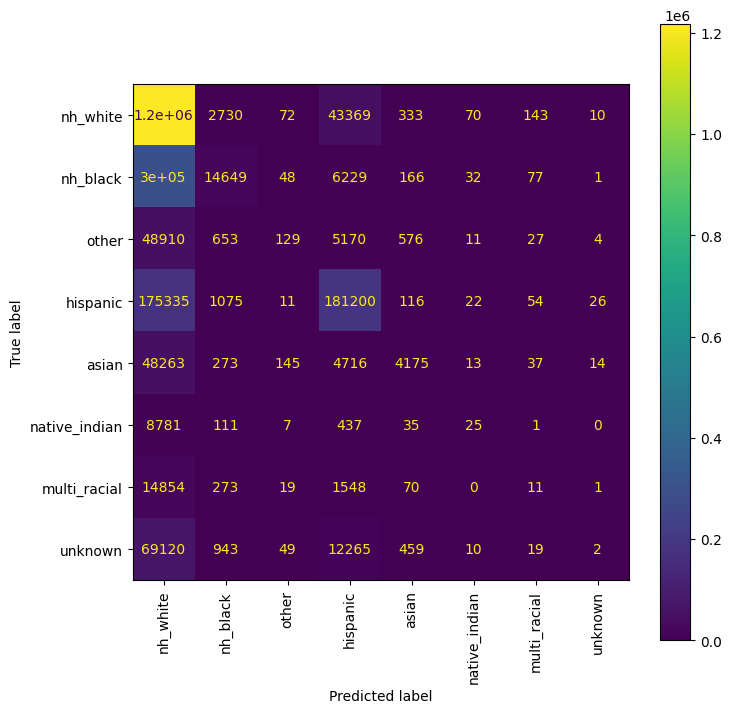

In [73]:
model_2m = joblib.load('fl_voter_name_gb_model_2M.joblib')
preds = model_2m.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

### For Model trained  with complete dataset (20 iterations)

/home/distill1994/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/distill1994/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/distill1994/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        asian       0.77      0.02      0.04     57636
     hispanic       0.74      0.36      0.48    357839
 multi_racial       0.00      0.00      0.00     16776
native_indian       0.00      0.00      0.00      9397
     nh_black       0.79      0.00      0.01    318456
     nh_white       0.62      0.98      0.76   1263354
        other       0.33      0.00      0.00     55480
      unknown       0.00      0.00      0.00     82867

     accuracy                           0.63   2161805
    macro avg       0.41      0.17      0.16   2161805
 weighted avg       0.63      0.63      0.53   2161805



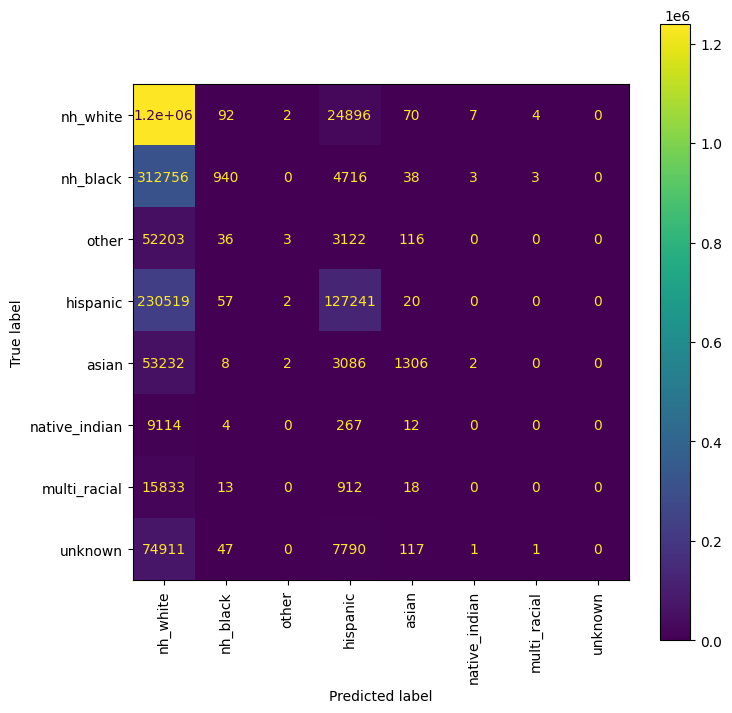

In [74]:
model_full = joblib.load('fl_voter_name_gb_model.joblib')
preds = model_full.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')